In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import * 
from utils.plot_functions import *
from utils.mog_functions import *


matplotlib.rcParams.update({'font.size': 18})

import numpy as np

import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt


# to do: debug sl in higher dim

%matplotlib inline

### Design and plot the posterior

Posterior Covariance Matrix (K):
 [[9. 0. 0.]
 [0. 9. 0.]
 [0. 0. 9.]]

Inverse Posterior Covariance Matrix (K_inv):
 [[0.11111111 0.         0.        ]
 [0.         0.11111111 0.        ]
 [0.         0.         0.11111111]]
Marginal integral values (should be ~1): [Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32)]


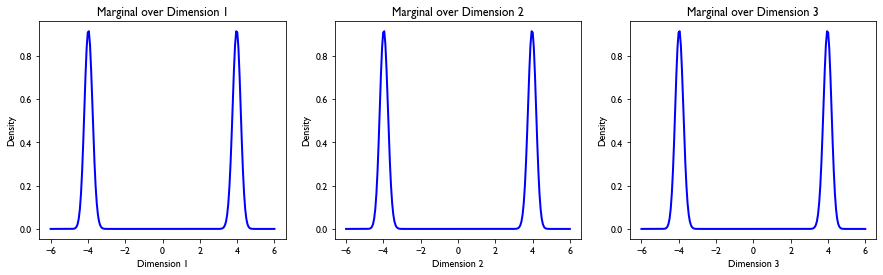

'\n# ✅ **Plot Multiple 2D Slices**\nnum_slices = min(3, d)  # Limit to max 3 for visualization\nfixed_values = jnp.zeros(d)  # Fix all other dimensions at zero\n\nfig, axes = plt.subplots(num_slices, num_slices, figsize=(5 * num_slices, 5 * num_slices))\n\nfor i in range(num_slices):\n    for j in range(i + 1, num_slices):\n        # Create a 2D slice grid\n        slice_axes = [grid_axes[i], grid_axes[j]]\n        slice_grid = jnp.meshgrid(*slice_axes, indexing="ij")\n\n        # Initialize a full d-dimensional grid with fixed values\n        full_slice = jnp.tile(fixed_values, (nb_grid**2, 1))  # Use `tile` to copy fixed values\n        full_slice = full_slice.at[:, i].set(slice_grid[0].ravel())  # Set axis i\n        full_slice = full_slice.at[:, j].set(slice_grid[1].ravel())  # Set axis j\n\n        # Compute posterior density for this slice\n        slice_V = eval_V(full_slice)\n        slice_V_clipped = jnp.clip(slice_V, a_min=-100, a_max=100)\n        slice_dens = jnp.exp(-slice

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from jax import grad, jit, vmap, jacfwd

# Dimension
d = 3  # Change as needed

# Observed data
y = jnp.zeros(1)

# Grid boundaries
xmin, xmax = -6, 6
ymin, ymax = -6, 6

# Noise levels
sigNoise = 3
sigPrior = 3  # Increased prior variance to prevent extreme `V(U)`
m0 = 0*jnp.ones((d,))

# Define JAX-compatible function G
def G(u):
    """Generalized observation function G: Computes sum of distances to two reference points."""
    vector1 = 4 * jnp.ones(d)   # Large positive vector
    vector2 = -4 * jnp.ones(d)  # Large negative vector
    return jnp.array([jnp.linalg.norm(u - vector1) * jnp.linalg.norm(u - vector2)]).reshape(-1, 1) # MOG case
    #return jnp.array([jnp.linalg.norm(u - vector1)]).reshape(-1, 1)

# Define likelihood term
def Phi(u):
    return 0.5 / (sigNoise**2) * jnp.sum((G(u).reshape(-1) - y.reshape(-1)) ** 2)

# Define posterior potential function V(u)
def V(u):
    return jnp.squeeze(0.5 / (sigPrior**2) * jnp.sum((u.reshape(d,) - m0) ** 2) + Phi(u.reshape(d,)))


target_potential_jax = lambda z: V(z)


# Compute gradient using JAX automatic differentiation
grad_V = jit(grad(V))
J_G = jit(jacfwd(G))

# Compute posterior covariance matrix
@jit
def compute_posterior_covariance():
    u_ref = jnp.zeros(d)  # Reference point
    g = J_G(u_ref).reshape(1, d)  # Ensure correct shape
    K_inv = jnp.eye(d) * (1 / sigPrior**2) + (1 / sigNoise**2) * g.T @ g
    K = jnp.linalg.inv(K_inv)  # Posterior covariance
    return K, K_inv

K, K_inv = compute_posterior_covariance()
print("Posterior Covariance Matrix (K):\n", K)
print("\nInverse Posterior Covariance Matrix (K_inv):\n", K_inv)

# ✅ **Grid setup**
nb_grid = 200
grid_axes = [jnp.linspace(xmin, xmax, nb_grid) for _ in range(d)]
U_mesh = jnp.meshgrid(*grid_axes, indexing="ij")

# Flatten and create grid points
U_flat = jnp.stack([U.ravel() for U in U_mesh], axis=1)  # Shape (nb_grid^d, d)

# ✅ **JIT-compiled evaluation of `V`**
@jax.jit
def eval_V(U):
    return jax.vmap(V)(U)  # Vectorized evaluation over all points

# ✅ **Compute posterior density**
V_vals = eval_V(U_flat)
V_clipped = jnp.clip(V_vals, a_min=-100, a_max=100)  # Prevent extreme exponentiation
unnorm_dens = jnp.exp(-V_clipped).reshape([nb_grid] * d)

# ✅ **Precompute normalization constant**
Z = jnp.trapz(unnorm_dens, grid_axes[0], axis=0)
#for i in range(1, d):
#    Z = jnp.trapz(Z, grid_axes[i], axis=0)
#Z = jnp.trapz(jnp.trapz(unnorm_dens, grid_axes[0], axis=0), grid_axes[1], axis=0)

dens = unnorm_dens / Z  # Normalized density

# ✅ **Compute 1D Marginals**
marginals = []
for i in range(d):
    marg = unnorm_dens
    for j in range(d):  
        if j != i:
            marg = jnp.trapz(marg, grid_axes[j], axis=0)  # ✅ Always integrate over axis 0
    # Normalize each marginal separately so it integrates to 1
    marg /= jnp.trapz(marg, grid_axes[i])  
    marginals.append(marg)

# ✅ **Check if marginals integrate to 1**
marginal_integrals = [jnp.trapz(marginals[i], grid_axes[i]) for i in range(d)]
print("Marginal integral values (should be ~1):", marginal_integrals)

# ✅ **Plot 1D Marginals**
fig, axes = plt.subplots(1, d, figsize=(5 * d, 4))

if d == 1:
    axes.plot(grid_axes[0], marginals[0], color="blue", linewidth=2)
    axes.set_title(f"Marginal over Dimension 1")
    axes.set_xlabel(f"Dimension 1")
    axes.set_ylabel("Density")
else:
    for i in range(d):
        axes[i].plot(grid_axes[i], marginals[i], color="blue", linewidth=2)
        axes[i].set_title(f"Marginal over Dimension {i+1}")
        axes[i].set_xlabel(f"Dimension {i+1}")
        axes[i].set_ylabel("Density")

plt.show()


"""
# ✅ **Plot Multiple 2D Slices**
num_slices = min(3, d)  # Limit to max 3 for visualization
fixed_values = jnp.zeros(d)  # Fix all other dimensions at zero

fig, axes = plt.subplots(num_slices, num_slices, figsize=(5 * num_slices, 5 * num_slices))

for i in range(num_slices):
    for j in range(i + 1, num_slices):
        # Create a 2D slice grid
        slice_axes = [grid_axes[i], grid_axes[j]]
        slice_grid = jnp.meshgrid(*slice_axes, indexing="ij")

        # Initialize a full d-dimensional grid with fixed values
        full_slice = jnp.tile(fixed_values, (nb_grid**2, 1))  # Use `tile` to copy fixed values
        full_slice = full_slice.at[:, i].set(slice_grid[0].ravel())  # Set axis i
        full_slice = full_slice.at[:, j].set(slice_grid[1].ravel())  # Set axis j

        # Compute posterior density for this slice
        slice_V = eval_V(full_slice)
        slice_V_clipped = jnp.clip(slice_V, a_min=-100, a_max=100)
        slice_dens = jnp.exp(-slice_V_clipped).reshape(nb_grid, nb_grid)  # Reshape properly

        # Plot contour of the slice
        ax = axes[i, j - 1]
        contour = ax.contour(slice_grid[0], slice_grid[1], slice_dens, levels=15, cmap="viridis")
        ax.clabel(contour, inline=1, fontsize=10)
        ax.set_title(f"Slice: Dimension {i+1} vs Dimension {j+1}")
        ax.set_xlabel(f"Dimension {i+1}")
        ax.set_ylabel(f"Dimension {j+1}")

plt.tight_layout()
plt.show()
"""

### Parameters of the algorithm

In [3]:
# Parameters of all algorithms
J = 20      # Number of particles
N_sim = 1000  # Number of iterations
tau = 1e-4# Step size

# Ensure mean and covariance have the correct shape
mean_init = 5 * jnp.ones(d) #np.zeros(d)  # Centered initialization in d dimensions
cov_init = np.eye(d) * 2  # Scaled identity matrix for covariance

# Parameters of our algorithm
const = 20

# Number of experiments
N_exp = 1

# Initialization
u0 = np.random.multivariate_normal(mean_init, cov_init, J).T  # Shape (d, J)

# For plots
val = 6


|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 3.5s (285.31/s▇▅▃ 989/1000 [99%] in 3s (~0s, 285.3/
(3, 20, 1000)
Histogram integral for dimension 1: 0.9987
Histogram integral for dimension 2: 0.9985
Histogram integral for dimension 3: 0.9974


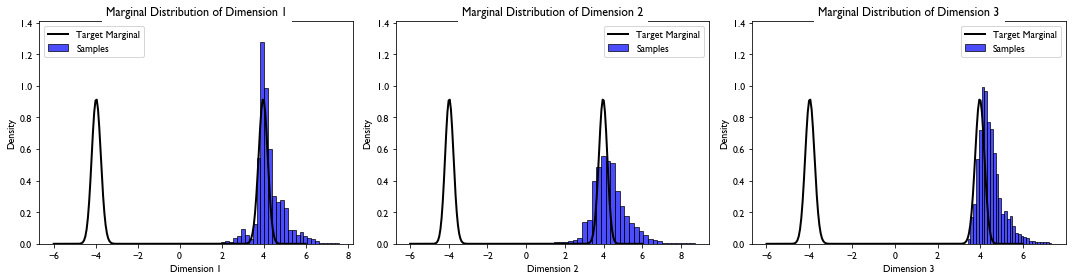

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 4.5s (223.35/s▇▅▃ 264/1000 [26%] in 1s (~4s, 206.7/in 3s (~1s, 223.5/
Histogram integral for dimension 1: 0.9994
Histogram integral for dimension 2: 0.9993
Histogram integral for dimension 3: 0.9910


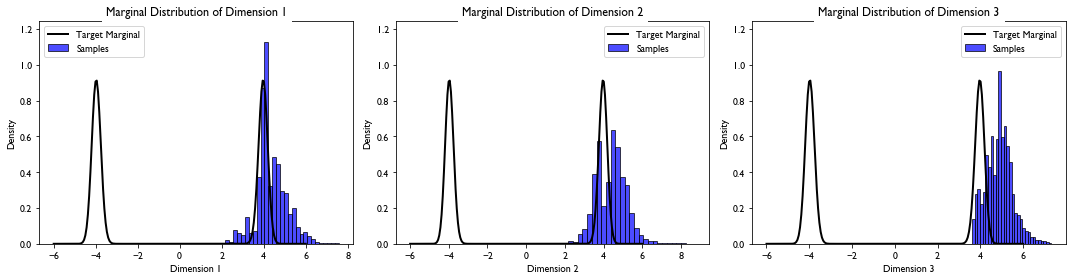

on 0: Iteration 0: Eigenvalues of C = [0.87114924 1.6787169  3.730419  ]        
on 0: Iteration 0: Condition number of C = 4.282179832458496                    
on 0: Particle std dev: [1.3288233  1.8822198  0.98577905]                      
on 0: [[ 1.7657713  -0.47778472  0.26321787]                                    
       [-0.47778472  3.542752   -0.37717646]
       [ 0.26321787 -0.37717646  0.97176015]]
on 0: 0.8711491                                                                 


on 0: /opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32. In future JAX releases this will result in an error.
        warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
        return lax_internal._convert_element_type(out, dtype, weak_type)


on 1: Iteration 1: Eigenvalues of C = [0.83608294 1.6787884  3.7378812 ]        
on 1: Iteration 1: Condition number of C = 4.470707893371582                    
on 1: Particle std dev: [1.3286637  1.8820466  0.97226846]                      
on 1: [[ 1.7653472  -0.4812097   0.27810028]                                    
       [-0.4812097   3.5420995  -0.39673278]
       [ 0.27810028 -0.39673278  0.94530594]]
on 1: 0.8360829                                                                 
on 2: Iteration 2: Eigenvalues of C = [0.820744  1.6788871 3.7450938]           
on 2: Iteration 2: Condition number of C = 4.563048839569092                    
on 2: Particle std dev: [1.3292229  1.88185    0.96774626]                      
on 2: [[ 1.7668333  -0.48558226  0.28726304]                                    
       [-0.48558226  3.541359   -0.41314274]
       [ 0.28726304 -0.41314274  0.9365327 ]]
on 2: 0.820744                                                                  
on 3: It

ValueError: C contains NaN or Inf values!

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

def plot_results(potential, us_list, tau, name, grid_axes, marginals, N_burnin=0, val=6):
    """
    Efficiently plots:
      - 2D contour (on a white background) + histogram + particles for d=2
      - 1D histograms for d > 2, with overlaid target marginals

    Args:
        potential: The posterior potential function.
        us_list: Array of shape (d, J, N_sim), storing particle positions over time.
        tau: Step size.
        name: Name of the algorithm.
        grid_axes: Grid points for marginals.
        marginals: List of 1D marginal densities from target.
        N_burnin: Number of burn-in steps to discard.
        val: Defines plot limits.
    """
    d, J, N_sim = us_list.shape  # Extract shape

    if d == 2:
        # ✅ **2D Contour Plot on White Background**
        fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

        @jax.jit
        def potential_vectorized(U):
            return jax.vmap(potential)(U)

        # Grid setup
        u0s = np.linspace(-val, val, 150)
        u1s = np.linspace(-val, val, 150)
        U0, U1 = np.meshgrid(u0s, u1s, indexing="ij")
        U = np.stack([U0.ravel(), U1.ravel()], axis=1)

        # Compute potential (JAX-accelerated)
        Z = np.array(potential_vectorized(U)).reshape(150, 150)

        # ✅ **Contour plot on a white background (no heatmap)**
        ax.contour(U0, U1, np.exp(-Z), levels=10, alpha=0.6, colors="black")

        # ✅ **2D Histogram of Past Positions**
        binsx = np.linspace(-val, val, 31)
        binsy = np.linspace(-val, val, 31)
        H, _, _ = np.histogram2d(
            np.ravel(us_list[0, :, N_burnin:]),
            np.ravel(us_list[1, :, N_burnin:]),
            bins=[binsx, binsy]
        )

        ax.pcolormesh(binsx, binsy, H.T, cmap="Blues", alpha=0.5)  # 🔵 Light blue histogram

        # ✅ **Scatter Plot for Start & End Positions**
        ax.scatter(us_list[0, :, 0], us_list[1, :, 0], color="purple", label="Start (N=0)")
        ax.scatter(us_list[0, :, -1], us_list[1, :, -1], color="red", label=f"End (N={N_sim})")

        ax.set_title(f"{name}, J={J}, N={N_sim}, $\\tau$={tau}", backgroundcolor="white")
        ax.set_xlim((-val, val))
        ax.set_ylim((-val, val))
        ax.set_aspect("equal")
        ax.legend()
        ax.set_facecolor("white")  # White background for contour plot
        plt.tight_layout()
        plt.show()

    # ✅ **1D Histograms with Target Marginals for d ≥ 1**
    fig, axes = plt.subplots(1, d, figsize=(5 * d, 4), squeeze=False, facecolor="white")
    axes = axes[0]  # Unpack 1D array

    # ✅ **Compute Common Y-Axis Scale**
    all_hist_max = 0
    hist_values = []
    for i in range(d):
        flattened_data = np.ravel(us_list[i, :, N_burnin:])
        hist, bin_edges = np.histogram(flattened_data, bins=30, density=True)
        hist_values.append((hist, bin_edges))
        all_hist_max = max(all_hist_max, hist.max(), marginals[i].max())

    for i in range(d):
        hist, bin_edges = hist_values[i]

        # ✅ Histogram using Matplotlib
        axes[i].hist(bin_edges[:-1], bins=bin_edges, weights=hist, density=True, alpha=0.7, color="blue", edgecolor="black", label="Samples")
        
        # ✅ **Overlay Target Marginals**
        axes[i].plot(grid_axes[i], marginals[i], color="black", linewidth=2, label="Target Marginal")

        # ✅ **Force Same Scale on Y-Axis**
        axes[i].set_ylim(0, all_hist_max * 1.1)  # Ensure all plots have same max y-axis

        # ✅ **Check if Histogram Integrates to 1**
        hist_integral = np.trapz(hist, bin_edges[:-1])  # Approximate integral
        print(f"Histogram integral for dimension {i+1}: {hist_integral:.4f}")

        # Labels
        axes[i].set_title(f"Marginal Distribution of Dimension {i+1}", backgroundcolor="white")
        axes[i].set_xlabel(f"Dimension {i+1}")
        axes[i].set_ylabel("Density")
        axes[i].set_facecolor("white")  # White background for individual histograms
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    
for j in range(N_exp):
    # ✅ Run ULA
    us_list_ULA = run_ULA(target_potential_jax, N_sim, u0, tau)
    print(us_list_ULA.shape)
    name = "ULA"
    plot_results(target_potential_jax, us_list_ULA, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDI
    us_list_ALDI = run_ALDI(target_potential_jax, N_sim, u0, tau)
    name = "ALDI"
    plot_results(target_potential_jax, us_list_ALDI, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDINR
    us_list_ALDINR = run_ALDINR(target_potential_jax, N_sim, u0, tau, const, print_lambda = True)
    name = "ALDINR"
    plot_results(target_potential_jax, us_list_ALDINR, tau, name, grid_axes, marginals, val=val)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

def plot_results(potential, us_list, tau, name, grid_axes, marginals, N_burnin=0, val=6):
    """
    Efficiently plots:
      - 2D contour (on a white background) + histogram + particles for d=2
      - 1D histograms for d > 2, with overlaid target marginals
      - Overlay histograms for the final iteration's particles

    Args:
        potential: The posterior potential function.
        us_list: Array of shape (d, J, N_sim), storing particle positions over time.
        tau: Step size.
        name: Name of the algorithm.
        grid_axes: Grid points for marginals.
        marginals: List of 1D marginal densities from target.
        N_burnin: Number of burn-in steps to discard.
        val: Defines plot limits.
    """
    d, J, N_sim = us_list.shape  # Extract shape

    if d == 2:
        # ✅ **2D Contour Plot on White Background**
        fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

        @jax.jit
        def potential_vectorized(U):
            return jax.vmap(potential)(U)

        # Grid setup
        u0s = np.linspace(-val, val, 150)
        u1s = np.linspace(-val, val, 150)
        U0, U1 = np.meshgrid(u0s, u1s, indexing="ij")
        U = np.stack([U0.ravel(), U1.ravel()], axis=1)

        # Compute potential (JAX-accelerated)
        Z = np.array(potential_vectorized(U)).reshape(150, 150)

        # ✅ **Contour plot on a white background (no heatmap)**
        ax.contour(U0, U1, np.exp(-Z), levels=10, alpha=0.6, colors="black")

        # ✅ **2D Histogram of Past Positions**
        binsx = np.linspace(-val, val, 31)
        binsy = np.linspace(-val, val, 31)
        H, _, _ = np.histogram2d(
            np.ravel(us_list[0, :, N_burnin:]),
            np.ravel(us_list[1, :, N_burnin:]),
            bins=[binsx, binsy]
        )

        ax.pcolormesh(binsx, binsy, H.T, cmap="Blues", alpha=0.5)  # 🔵 Light blue histogram

        # ✅ **Scatter Plot for Start & End Positions**
        ax.scatter(us_list[0, :, 0], us_list[1, :, 0], color="purple", label="Start (N=0)")
        ax.scatter(us_list[0, :, -1], us_list[1, :, -1], color="red", label=f"End (N={N_sim})")

        ax.set_title(f"{name}, J={J}, N={N_sim}, $\\tau$={tau}", backgroundcolor="white")
        ax.set_xlim((-val, val))
        ax.set_ylim((-val, val))
        ax.set_aspect("equal")
        ax.legend()
        ax.set_facecolor("white")  # White background for contour plot
        plt.tight_layout()
        plt.show()

    # ✅ **1D Histograms with Target Marginals for d ≥ 1**
    fig, axes = plt.subplots(1, d, figsize=(5 * d, 4), squeeze=False, facecolor="white")
    axes = axes[0]  # Unpack 1D array

    # ✅ **Precompute All Histogram and Marginal Values to Set Common Y-Axis Scale**
    all_hist_max = 0
    hist_values = []
    last_iteration_values = []
    
    for i in range(d):
        flattened_data = np.ravel(us_list[i, :, N_burnin:])
        last_iteration = np.ravel(us_list[i, :, -1])  # Last iteration's particles

        hist, bin_edges = np.histogram(flattened_data, bins=30, density=True)
        hist_values.append((hist, bin_edges))

        hist_last, bin_edges_last = np.histogram(last_iteration, bins=30, density=True) #bins = 30
        last_iteration_values.append((hist_last, bin_edges_last))

        # ✅ Update max y-scale across ALL dimensions
        all_hist_max = max(all_hist_max, hist.max(), hist_last.max(), marginals[i].max())

    # ✅ **Now plot all histograms with the same y-axis scale**
    for i in range(d):
        hist, bin_edges = hist_values[i]
        hist_last, bin_edges_last = last_iteration_values[i]

        # ✅ Histogram of full particle history
        axes[i].hist(bin_edges[:-1], bins=bin_edges, weights=hist, density=True, alpha=0.5, color="blue", edgecolor="black", label="Samples (All)")

        # ✅ Histogram of last iteration's particles
        axes[i].hist(bin_edges_last[:-1], bins=bin_edges_last, weights=hist_last, density=True, alpha=0.5, color="red", edgecolor="black", label="Samples (Final)")

        # ✅ **Overlay Target Marginals**
        axes[i].plot(grid_axes[i], marginals[i], color="black", linewidth=2, label="Target Marginal")

        # ✅ **Force Same Scale on Y-Axis**
        axes[i].set_ylim(0, all_hist_max * 1.1)  # Ensure all plots have same max y-axis

        # ✅ **Check if Histogram Integrates to 1**
        hist_integral = np.trapz(hist, bin_edges[:-1])  # Approximate integral
        hist_last_integral = np.trapz(hist_last, bin_edges_last[:-1])
        print(f"Histogram integral for dimension {i+1} (All): {hist_integral:.4f}")
        print(f"Histogram integral for dimension {i+1} (Final): {hist_last_integral:.4f}")

        # Labels
        axes[i].set_title(f"Marginal Distribution of Dimension {i+1}", backgroundcolor="white")
        axes[i].set_xlabel(f"Dimension {i+1}")
        axes[i].set_ylabel("Density")
        axes[i].set_facecolor("white")  # White background for individual histograms
        axes[i].legend()

    plt.tight_layout()
    plt.show()


# ✅ **Run simulations and plot results**
for j in range(N_exp):
    # ✅ Run ULA
    us_list_ULA = run_ULA(target_potential_jax, N_sim, u0, tau)
    print(us_list_ULA.shape)
    name = "ULA"
    plot_results(target_potential_jax, us_list_ULA, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDI
    us_list_ALDI = run_ALDI(target_potential_jax, N_sim, u0, tau)
    name = "ALDI"
    plot_results(target_potential_jax, us_list_ALDI, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDINR
    us_list_ALDINR = run_ALDINR(target_potential_jax, N_sim, u0, tau, const)
    name = "ALDINR"
    plot_results(target_potential_jax, us_list_ALDINR, tau, name, grid_axes, marginals, val=val)


### Algorithms with statistical linearization 

In [ ]:
import jax
import jax.numpy as jnp
import scipy.linalg
import matplotlib.pyplot as plt
import numpy as np
from alive_progress import alive_bar

def plot_results(potential, us_list, tau, name, grid_axes, marginals, N_burnin=0, val=6):
    """
    Plots:
      - 2D contour plot + histogram for d=2
      - 1D histograms for d > 2 with overlaid target marginals
      - Includes marginals of **final iteration particles**.

    Args:
        potential: The posterior potential function.
        us_list: Array of shape (d, J, N_sim), storing particle positions over time.
        tau: Step size.
        name: Name of the algorithm.
        grid_axes: Grid points for marginals.
        marginals: List of 1D marginal densities from target.
        N_burnin: Number of burn-in steps to discard.
        val: Defines plot limits.
    """
    d, J, N_sim = us_list.shape  # Extract shape

    if d == 2:
        fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

        @jax.jit
        def potential_vectorized(U):
            return jax.vmap(potential)(U)

        # Grid setup
        u0s = np.linspace(-val, val, 150)
        u1s = np.linspace(-val, val, 150)
        U0, U1 = np.meshgrid(u0s, u1s, indexing="ij")
        U = np.stack([U0.ravel(), U1.ravel()], axis=1)

        # Compute potential (JAX-accelerated)
        Z = np.array(potential_vectorized(U)).reshape(150, 150)

        # ✅ **Contour plot on a white background (no heatmap)**
        ax.contour(U0, U1, np.exp(-Z), levels=10, alpha=0.6, colors="black")

        # ✅ **2D Histogram of Past Positions**
        binsx = np.linspace(-val, val, 31)
        binsy = np.linspace(-val, val, 31)
        H, _, _ = np.histogram2d(
            np.ravel(us_list[0, :, N_burnin:]),
            np.ravel(us_list[1, :, N_burnin:]),
            bins=[binsx, binsy]
        )

        ax.pcolormesh(binsx, binsy, H.T, cmap="Blues", alpha=0.5)  # 🔵 Light blue histogram

        # ✅ **Scatter Plot for Start & End Positions**
        ax.scatter(us_list[0, :, 0], us_list[1, :, 0], color="purple", label="Start (N=0)")
        ax.scatter(us_list[0, :, -1], us_list[1, :, -1], color="red", label=f"End (N={N_sim})")

        ax.set_title(f"{name}, J={J}, N={N_sim}, $\\tau$={tau}", backgroundcolor="white")
        ax.set_xlim((-val, val))
        ax.set_ylim((-val, val))
        ax.set_aspect("equal")
        ax.legend()
        ax.set_facecolor("white")  # White background for contour plot
        plt.tight_layout()
        plt.show()

    # ✅ **1D Histograms with Target Marginals for d ≥ 1**
    fig, axes = plt.subplots(1, d, figsize=(5 * d, 4), squeeze=False, facecolor="white")
    axes = axes[0]  # Unpack 1D array

    # ✅ **Compute Common Y-Axis Scale**
    all_hist_max = 0
    hist_values = []
    last_iteration_values = []
    
    for i in range(d):
        flattened_data = np.ravel(us_list[i, :, N_burnin:])
        last_iteration = np.ravel(us_list[i, :, -1])  # Last iteration's particles

        hist, bin_edges = np.histogram(flattened_data, bins=30, density=True)
        hist_values.append((hist, bin_edges))

        hist_last, bin_edges_last = np.histogram(last_iteration, bins=30, density=True)
        last_iteration_values.append((hist_last, bin_edges_last))

        all_hist_max = max(all_hist_max, hist.max(), hist_last.max(), marginals[i].max())

    for i in range(d):
        hist, bin_edges = hist_values[i]
        hist_last, bin_edges_last = last_iteration_values[i]

        # ✅ Histogram of full particle history
        axes[i].hist(bin_edges[:-1], bins=bin_edges, weights=hist, density=True, alpha=0.5, color="blue", edgecolor="black", label="Samples (All)")

        # ✅ Histogram of last iteration's particles
        axes[i].hist(bin_edges_last[:-1], bins=bin_edges_last, weights=hist_last, density=True, alpha=0.5, color="red", edgecolor="black", label="Samples (Final)")

        # ✅ **Overlay Target Marginals**
        axes[i].plot(grid_axes[i], marginals[i], color="black", linewidth=2, label="Target Marginal")

        # ✅ **Force Same Scale on Y-Axis**
        axes[i].set_ylim(0, all_hist_max * 1.1)  # Ensure all plots have same max y-axis

        # ✅ **Check if Histogram Integrates to 1**
        hist_integral = np.trapz(hist, bin_edges[:-1])  # Approximate integral
        hist_last_integral = np.trapz(hist_last, bin_edges_last[:-1])
        print(f"Histogram integral for dimension {i+1} (All): {hist_integral:.4f}")
        print(f"Histogram integral for dimension {i+1} (Final): {hist_last_integral:.4f}")

        # Labels
        axes[i].set_title(f"Marginal Distribution of Dimension {i+1}", backgroundcolor="white")
        axes[i].set_xlabel(f"Dimension {i+1}")
        axes[i].set_ylabel("Density")
        axes[i].set_facecolor("white")  # White background for individual histograms
        axes[i].legend()

    plt.tight_layout()
    plt.show()


# ✅ **Run simulations and plot results**
for j in range(N_exp):
    # ✅ Run ULA
    us_list_ULA = run_ULA_SL(G, y, N_sim, u0, tau)
    print(us_list_ULA.shape)
    name = "ULA"
    plot_results(target_potential_jax, us_list_ULA, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDI
    us_list_ALDI = run_ALDI_SL(G, y, N_sim, u0, tau)
    name = "ALDI"
    plot_results(target_potential_jax, us_list_ALDI, tau, name, grid_axes, marginals, val=val)

    # ✅ Run ALDINR
    us_list_ALDINR = run_ALDINR_SL(G, y, N_sim, u0, tau, const)
    name = "ALDINR"
    plot_results(target_potential_jax, us_list_ALDINR, tau, name, grid_axes, marginals, val=val)
